In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from scripts import class_scripts, light

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import dataset
data = pd.read_pickle('../data/data_outputs/feature_engineered/cleaned_dataset.pkl')

In [8]:
# Splitting train, test and validation sets
df_train, df_test = train_test_split(data, test_size = 0.35, random_state = 42)

# LightGBM model

Réaliser un split sur plusieurs fold, puis blending

In [9]:
y_pred = light.kfold_lightgbm(df_train, df_test, 
                              num_folds=5, 
                              stratified = True, 
                              n_estimators = 5000, 
                              return_pred = True)

Starting LightGBM. Train shape: (199879, 380), test shape: (107628, 380)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.809661	training's binary_logloss: 0.231956	valid_1's auc: 0.769887	valid_1's binary_logloss: 0.244132
[400]	training's auc: 0.845512	training's binary_logloss: 0.217967	valid_1's auc: 0.778116	valid_1's binary_logloss: 0.240882
[600]	training's auc: 0.872743	training's binary_logloss: 0.207443	valid_1's auc: 0.780355	valid_1's binary_logloss: 0.240089
[800]	training's auc: 0.893649	training's binary_logloss: 0.198533	valid_1's auc: 0.781167	valid_1's binary_logloss: 0.239788
[1000]	training's auc: 0.910581	training's binary_logloss: 0.190509	valid_1's auc: 0.781182	valid_1's binary_logloss: 0.239793
Early stopping, best iteration is:
[910]	training's auc: 0.903494	training's binary_logloss: 0.193994	valid_1's auc: 0.781272	valid_1's binary_logloss: 0.239793
Fold  1 AUC : 0.781272
Training until validation scores don't improve for

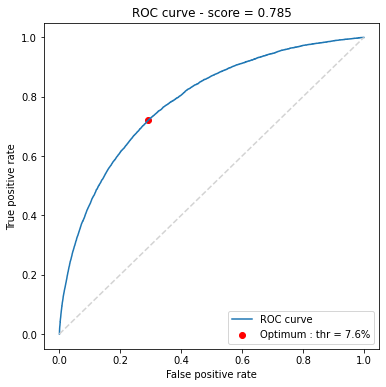

In [10]:
# Prediction and score
plt.figure(figsize = (6,6))
y_test = df_test['TARGET']
class_scripts.plot_roc(y_test, y_pred)
plt.show()

# Kaggle submission

In [3]:
# Load test set
data_test = pd.read_pickle('../data/data_outputs/feature_engineered/cleaned_dataset_test.pkl')

In [4]:
# Prediction for test set
y_pred = light.kfold_lightgbm(data, data_test, 
                              num_folds=5, 
                              stratified = True, 
                              n_estimators = 5000, 
                              return_pred = True)

Starting LightGBM. Train shape: (307507, 380), test shape: (48744, 380)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.797497	training's binary_logloss: 0.235276	valid_1's auc: 0.772269	valid_1's binary_logloss: 0.242756
[400]	training's auc: 0.825378	training's binary_logloss: 0.224536	valid_1's auc: 0.782489	valid_1's binary_logloss: 0.238703
[600]	training's auc: 0.847112	training's binary_logloss: 0.216662	valid_1's auc: 0.785378	valid_1's binary_logloss: 0.237646
[800]	training's auc: 0.864839	training's binary_logloss: 0.21006	valid_1's auc: 0.786173	valid_1's binary_logloss: 0.237338
[1000]	training's auc: 0.879781	training's binary_logloss: 0.204022	valid_1's auc: 0.786579	valid_1's binary_logloss: 0.23717
[1200]	training's auc: 0.892766	training's binary_logloss: 0.198412	valid_1's auc: 0.786849	valid_1's binary_logloss: 0.237044
[1400]	training's auc: 0.90408	training's binary_logloss: 0.193165	valid_1's auc: 0.786943	valid_1's binary_lo

In [5]:
# Export submission
df_submission = pd.DataFrame(y_pred, index = data_test['SK_ID_CURR'])
df_submission.to_csv('submission.csv')

# Storing the model

In [18]:
classifiers = light.kfold_lightgbm(df_train.iloc[:100], df_test.iloc[:100], 
                              num_folds=5, 
                              stratified = True, 
                              n_estimators = 5000, 
                              return_clf = True)

Starting LightGBM. Train shape: (100, 380), test shape: (100, 380)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0634565	valid_1's auc: 0.666667	valid_1's binary_logloss: 0.351375
Early stopping, best iteration is:
[2]	training's auc: 0.918623	training's binary_logloss: 0.346241	valid_1's auc: 0.555556	valid_1's binary_logloss: 0.325317
Fold  1 AUC : 0.555556
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0732775	valid_1's auc: 0.722222	valid_1's binary_logloss: 0.317343
Early stopping, best iteration is:
[52]	training's auc: 1	training's binary_logloss: 0.218212	valid_1's auc: 0.611111	valid_1's binary_logloss: 0.308074
Fold  2 AUC : 0.611111
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0578842	valid_1's auc: 0.472222	valid_1's binary_logloss: 0.52749
Early stopping, best iteration

In [24]:
class FinalClassifier():
    
    def fit(self, df_train, df_test, n_folds):
        self.clfs_ = light.kfold_lightgbm(df_train, df_test, 
                              num_folds=n_folds, 
                              stratified = True, 
                              n_estimators = 5000, 
                              return_clf = True)
        
    def predict_proba(self, df_test):
        y_pred = np.zeros(df_test.shape[0])
        feats = [f for f in df_test.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index', 'source']]
        for clf in self.clfs_:
            y_pred += clf.predict_proba(df_test[feats])[:,1]/len(self.clfs_)
        return y_pred
        

In [25]:
fc = FinalClassifier()
fc.fit(df_train.iloc[:100], df_test.iloc[:100], n_folds=5)
y_pred = fc.predict_proba(df_test.iloc[:100])

Starting LightGBM. Train shape: (100, 380), test shape: (100, 380)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0634565	valid_1's auc: 0.666667	valid_1's binary_logloss: 0.351375
Early stopping, best iteration is:
[2]	training's auc: 0.918623	training's binary_logloss: 0.346241	valid_1's auc: 0.555556	valid_1's binary_logloss: 0.325317
Fold  1 AUC : 0.555556
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0732775	valid_1's auc: 0.722222	valid_1's binary_logloss: 0.317343
Early stopping, best iteration is:
[52]	training's auc: 1	training's binary_logloss: 0.218212	valid_1's auc: 0.611111	valid_1's binary_logloss: 0.308074
Fold  2 AUC : 0.611111
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 1	training's binary_logloss: 0.0578842	valid_1's auc: 0.472222	valid_1's binary_logloss: 0.52749
Early stopping, best iteration

In [26]:
y_pred

array([0.16038496, 0.08582042, 0.1410202 , 0.09387772, 0.10769459,
       0.10147665, 0.10780955, 0.14165373, 0.09531946, 0.09727417,
       0.1221894 , 0.1241562 , 0.14103922, 0.08769286, 0.09360208,
       0.09076418, 0.14843886, 0.15975491, 0.12365899, 0.16966707,
       0.11970022, 0.10246062, 0.16149968, 0.13922681, 0.09639014,
       0.14006152, 0.09391386, 0.09655235, 0.08867065, 0.10829908,
       0.1538405 , 0.08934436, 0.10688699, 0.12455744, 0.12492152,
       0.0915411 , 0.09417652, 0.09237216, 0.11907486, 0.083749  ,
       0.09403835, 0.09744941, 0.1235959 , 0.10682287, 0.09912064,
       0.09644119, 0.09471873, 0.09902323, 0.10342919, 0.08396399,
       0.08978765, 0.11068009, 0.09097881, 0.10334729, 0.13944412,
       0.14559143, 0.10229438, 0.11712619, 0.09990187, 0.1030398 ,
       0.11129703, 0.10955473, 0.0968518 , 0.08780413, 0.09947597,
       0.1153819 , 0.08898652, 0.09064172, 0.13251433, 0.13680258,
       0.12825489, 0.137104  , 0.12508586, 0.08944384, 0.15752

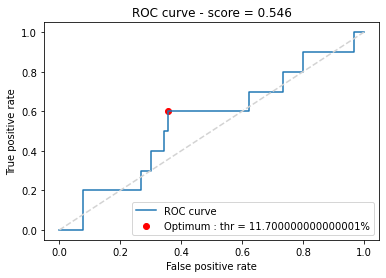

In [28]:
class_scripts.plot_roc(df_test.iloc[:100]['TARGET'], y_pred)